![](figs/se_03.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [15]:
from pathlib import Path
import sys

helper_utils = Path.cwd().parent
sys.path.append(str(helper_utils))

import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# 1. PyTorch workflow
***
The previous session we had a look at the basics of neural networks and how to train a single layer perceptron. In this session we will look at the PyTorch framework and how to use it to build and train neural networks.

Most deep learning projects follow a similar workflow. The following figure illustrates the typical workflow of a PyTorch project:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\pytorch_workflow.png" alt="PyTorch WorkFlow" align="center" style="width: 80%; height: auto; margin: 0 auto;">
</figure>

The workflow consists of the following steps:

| Step | Description |
|------|----------|
| Obtain Data | Collect and preprocess the data for training and testing |
| Prepare Data | Setup data in PyTorch format |
| Pre-process Data | Normalize and augment the data. This may involve data cleaning, normalization, and splitting the data into training, validation, and test sets. |
| Activation Function | Choose an activation function for the model. This may involve selecting a suitable activation function for the model, such as ReLU, sigmoid, or tanh. |
| Model | Define the model architecture. |
| Choose optimiser | Select an optimiser for the model. |
| Choose loss function | Select a loss function for the model. |
| Create training loop | Define the training steps, including forward pass, backward pass, and parameter updates. |
| Fit model | Train the model using the training data. |
| Evaluate model | Evaluate the model using the validation and test data to make predictions |
| Improve model | Fine-tune the model by adjusting hyperparameters, adding regularization, or modifying the architecture. |
| Save or deploy model | Save the trained model for future use or deploy it in a production environment. |

## Step 1: Obtain Data
***
In this notebook we are going to be using the [ARKOMA dataset](https://www.sciencedirect.com/science/article/pii/S2352340923007989). The dataset is intended to be used as a benchmark for the creation of Neural Networks to perform inverse kinematics for robotic arms using a NAO robot. The dataset contains data for two different robotic arms: the left arm and the right arm. The data is generated using a physics engine that simulates the movement of the robotic arms in a 3D environment. The dataset contain 10,000 input-output data pairs for both arms. The input data is the end-effector position of the robotic arm, and the output data is the joint angles of the robotic arm. 

The input parameters are:
| Notation | Description |
|------|----------|
| $ P_{x} $ | The end-effector position with respect to the torso's x-axis |
| $ P_{y} $ | The end-effector position with respect to the torso's y-axis |
| $ P_{z} $ | The end-effector position with respect to the torso's z-axis |
| $ R_{x} $ | The end-effector orientation relative to the torso's x-axis |
| $ R_{y} $ | The end-effector orientation relative to the torso's y-axis |
| $ R_{z} $ | The end-effector orientation relative to the torso's z-axis |

The output parameters are:

| Notation | Left Arm Joint | Left Arm Range(rad) | Right Arm Joint | Right Arm Range(rad) |
|----------|----------------|--------------------|-----------------|--------------------|
| $ \theta_{1} $ | LShoulder Pitch | [-2.0857, 2.0857] | RShoulder Pitch | [-2.0857, 2.0857] |
| $ \theta_{2} $ | LShoulder Roll | [-0.3142, 1.3265] | RShoulder Roll | [-1.3265, 0.3142] |
| $ \theta_{3} $ | LElbow Yaw | [-2.0857, 2.0857] | RElbow Yaw | [-2.0857, 2.0857] |
| $ \theta_{4} $ | LElbow Roll | [-1.5446, 0.0349] | RElbow Roll | [-0.0349, 1.5446] |
| $ \theta_{5} $ | LWrist Yaw | [-1.8238, 1.8238] | RWrist Yaw | [-1.8238, 1.8238]  |

In this notebook, we are going to focus on the right arm. The data is stored in CSV format. To load the data, we will use the `pandas` library. 

In [20]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('ARKOMA',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)

dataset_path = dataset_path / 'Dataset on NAO Robot Arms'

Downloading:
ARKOMA: The Dataset to Build Neural Networks-Based Inverse Kinematics for NAO Robot Arms
> Authors: Arif Nugroho, Eko Mulyanto Yuniarno, Mauridhi Hery Purnomo
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340923007989



Extracting Dataset on NAO Robot Arms.zip: 100%|██████████| 15/15 [00:00<00:00, 1040.53it/s]


## Step 2 and 3: Prepare and Pre-process Data
***
The next step is to pre-process the data. This involves normalizing the data and splitting it into training, validation, and test sets.

### Training, Validation, and Test Sets
***
One of the crucial steps in machine learning is to split the data into training, validation, and test sets. Each of these sets serves a specific purpose in the model development process:

| Dataset | Purpose | Typical Split | Usage | Analogy |
|---------|---------|---------------|--------|----------|
| Training Set | Used to train the model by adjusting weights and biases through backpropagation | 60-80% | Every training iteration | Like studying materials to learn a subject |
| Validation Set | Used to tune hyperparameters and monitor model performance during training to prevent overfitting | 10-20% | During model development | Like practice exams to gauge learning progress |
| Test Set | Used only once for final model evaluation; never used for training or tuning | 10-20% | Once, after training | Like a final exam with new, unseen questions |

The ARKOMA dataset has already been split into these three sets for us, which simplifies our workflow.

> **Note**: The test set is our generalisation benchmark. It is important to keep the test set separate from the training and validation sets to ensure that the model's performance is evaluated on unseen data. This helps us understand how well the model will perform in real-world scenarios. 

In [21]:
# Set the path to the datasets 
right_arm_path = dataset_path / 'Right Arm Dataset'
feats_train = right_arm_path / 'RTrain_x.csv'
targets_train = right_arm_path / 'RTrain_y.csv'
feats_val = right_arm_path / 'RVal_x.csv'
targets_val = right_arm_path / 'RVal_y.csv'
feats_test = right_arm_path / 'RTest_x.csv'
targets_test = right_arm_path / 'RTest_y.csv'

In [22]:
# Load the datasets
X_train = pd.read_csv(feats_train)
y_train = pd.read_csv(targets_train)
X_val = pd.read_csv(feats_val)
y_val = pd.read_csv(targets_val)
X_test = pd.read_csv(feats_test)
y_test = pd.read_csv(targets_test)

X_train.shape, y_train.shape

((6000, 6), (6000, 5))

In [23]:
X_train.head()

,Px,Py,Pz,Rx,Ry,Rz
0,116.12,-180.97,198.59,-10.39,-41.23,5.04
1,83.41,-228.19,-25.54,24.58,52.19,-43.12
2,45.81,-187.38,285.07,2.08,-81.96,-9.99
3,112.87,-146.16,-74.21,-19.96,56.73,13.66
4,175.85,-162.01,41.35,-21.91,5.63,10.07


In [24]:
y_train.head()

,joint1,joint2,joint3,joint4,joint5
0,-0.98727,-1.03049,-0.29515,1.19638,0.01696
1,0.49338,-0.92155,-1.00017,0.70232,1.33316
2,-1.32138,-0.60855,0.25970,0.48005,-0.29894
3,0.85806,-0.32185,-0.41366,0.38794,-0.00819
4,0.46961,-0.66923,0.44363,0.88413,-0.74223


In [25]:
# Creating the tensor datasets
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### Normalisation
***
Normalisation is a crucial step in the pre-processing of data for machine learning models. It involves scaling the input features to a similar range, which helps improve the convergence speed and performance of the model. In this notebook, we will use Min-Max normalization to scale the input features to a range of [0, 1]. The formula for Min-Max normalization is as follows:
$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Where:
- $ X_{norm} $ is the normalized value.
- $ X$ is the original value.
- $ X_{min} $ is the minimum value of the feature.
- $ X_{max} $ is the maximum value of the feature.

The normalisation parameters will be computed from the training set and then applied to the validation and test sets. This helps to prevent data leakage and ensures that the model is evaluated on unseen data. 

In [26]:
x_scaler = utils.ml.CustomScaler(method='minmax')
y_scaler = utils.ml.CustomScaler(method='minmax')

# Fit the scalers to the training data
x_scaler.fit(X_train_tensor)
y_scaler.fit(y_train_tensor)

# Transform the training, validation, and test data
X_train_tensor = x_scaler.transform(X_train_tensor)
y_train_tensor = y_scaler.transform(y_train_tensor)
X_val_tensor = x_scaler.transform(X_val_tensor)
y_val_tensor = y_scaler.transform(y_val_tensor)
X_test_tensor = x_scaler.transform(X_test_tensor)
y_test_tensor = y_scaler.transform(y_test_tensor)

In [ ]:
# Check the min and max values of the scaled data
X_train_tensor.min(), X_train_tensor.max(), y_train_tensor.min(), y_train_tensor.max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data.

| Function | Formula | Range | Characteristics | Best Used For |
|----------|---------|-------|-----------------|---------------|
| ReLU | $f(x) = \max(0, x)$ | $[0, \infty)$ | Linear for positive values, zero for negative | Hidden layers in most networks |
| Sigmoid | $f(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | S-shaped curve, saturates at extremes | Binary classification, gates in LSTMs |
| Tanh | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | S-shaped curve, zero-centered | Hidden layers when output normalization is needed |
| Leaky ReLU | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | Small slope for negative values | Preventing "dead neurons" problem |


## Step 5: Model
***
The next step is to define the model architecture. In this case, we are going to use a simple feedforward neural network with one hidden layer. The model will consist of the following layers:
- Input layer: 6 input features (end-effector position and orientation)
- Hidden layer: 32 neurons with Sigmoid activation function
- Output layer: 5 output features (joint angles of the right arm)

## Layers 

In order to create a Neural Network we need to stack multiple neurons together. This is known as a **layer**. A layer is a collection of neurons that work together to process the input data. A simple ANN is formed by three types of layers:
   - **Input Layer**: Receives the input data.
   - **Hidden Layers**: Intermediate layers that process the data.
   - **Output Layer**: Produces the final output.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\layers.png" alt="ANN layers" align="center" style="width: 20%; height: auto; margin: 0 auto;">
</figure>

We are going to be using the `torch.nn` module to create our layers. The `torch.nn` module provides a wide range of pre-defined layers that can be used to build neural networks. Some of the most commonly used layers include:
- `torch.nn.Linear`: A fully connected layer that applies a linear transformation to the input data.
- `torch.nn.Conv2d`: A convolutional layer that applies a convolution operation to the input data. This is commonly used in image processing tasks.


### Initialising Weights and Biases
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Initialising weights and biases is the process of assigning initial values to these parameters before training a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |

In [28]:
class ANNv1 (torch.nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_units)
        self.out = torch.nn.Linear(hidden_units, output_size)
        self.act = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.out(x)

        return x

In [29]:
model_v1 = ANNv1(input_size=6,
                 hidden_units=32,
                 output_size=5)
model_v1

ANNv1(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=5, bias=True)
  (act): Sigmoid()
)

### Step 6: Choose Optimiser
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Optimisers are algorithms used to update the model parameters during training to minimise the loss function.

The next step is to choose an optimiser for the model.



The optimiser algorithm is used to update the model parameters during training. Most optimizers use a version of gradient descent to update the model parameters. The goal of the optimiser is to minimize the loss function by adjusting the weights and biases of the model. The most commonly used optimizers include:

- **Stochastic Gradient Descent (SGD):** A simple and widely used optimizer that updates the model parameters using the gradients of the loss function.
- **Adam:** An adaptive learning rate optimizer that combines the benefits of both SGD and RMSProp. It is widely used in deep learning applications due to its efficiency and effectiveness.
- **RMSProp:** An adaptive learning rate optimizer that adjusts the learning rate based on the average of recent gradients. It is particularly useful for training deep neural networks.
- **Adagrad:** An adaptive learning rate optimizer that adjusts the learning rate based on the historical gradients. It is particularly useful for sparse data.

The Adam optimiser is a popular choice for training deep learning models due to its efficiency and effectiveness. It combines the benefits of both SGD and RMSProp, making it suitable for a wide range of tasks.

### Learning Rate
***
The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A small learning rate may lead to slow convergence, while a large learning rate may cause the model to diverge. It is important to choose an appropriate learning rate for the optimizer to work effectively

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\learning_rate.png" alt="Gradient Descent" align="center" style="width: 50%; height: auto; margin: 0 auto;">
</figure>



In [30]:
optim = torch.optim.Adam(params=model_v1.parameters(),
                         lr=1e-2)
criterion = torch.nn.MSELoss()

model_v1.criterion = criterion
model_v1.optim = optim

### Step 7: Choose Loss Function
The next step is to choose a loss function for the model. In this case, we are going to use Mean Squared Error (MSE) loss function. The MSE loss function is commonly used for regression tasks and measures the average squared difference between the predicted and actual values. The formula for MSE is as follows:
$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2} $$

Where:
- $ n $ is the number of samples in the dataset.
- $ y_{i} $ is the actual value.
- $ \hat{y}_{i} $ is the predicted value.
- $ MSE $ is the mean squared error.

In PyTorch, the optimiser takes the model parameters as input and the learning rate as a hyperparameter.

The loss is also a PyTorch module that takes the model output and the target output as input. The loss function computes the loss value, which is then used to update the model parameters during training.

### Step 8: Create Training Loop
The next step is to create the training loop. The training loop consists of the following steps:

- Forward pass: The input data is passed through the model, and the output is computed.
- Compute loss: The loss is computed using the predicted output and the target output.
- Backward pass: The gradients of the loss function with respect to the model parameters are computed using backpropagation.
- Update parameters: The model parameters are updated using the computed gradients and the optimiser.
- Monitor performance: The training and validation loss is monitored during training to prevent overfitting.



> **Note**: The output of the layer in this case returns a tensor and `grad_fn` which is a reference to the function that created the tensor. This is used by PyTorch to keep track of the operations that have been performed on the tensor. This is important for the training process as it allows PyTorch to compute the gradients of the loss function with respect to the model parameters.

In [31]:
def train(model: torch.nn.Module,
          features: torch.Tensor,
          targets: torch.Tensor,
          val_features: torch.Tensor,
          val_targets: torch.Tensor,
          epochs: int):
    
    # Set the model to training mode
    # Enables certain layers to behave differently during training and evaluation
    # e.g., dropout layers will drop units during training but not during evaluation
    model.train()

    # Keep track of the training and validation loss
    # for each epoch
    train_loss = []
    val_loss = []

    with tqdm(range(epochs), desc=f"Training {model.__class__.__name__}", dynamic_ncols=True) as pbar:
        
        for epoch in pbar:
            # The optimizer is set to zero the gradients
            # of the model parameters before each training step
            # This is important because gradients accumulate by default in PyTorch
            # If we don't zero the gradients, the gradients from the previous step will be added to the current step
            model.optim.zero_grad()

            # ------ Forward pass
            y_pred = model(features)
            # Compute the loss
            loss = model.criterion(y_pred, targets)
            # Append the loss to the training loss list
            # Convert the loss to a scalar value and append it to the list
            train_loss.append(loss.item())
            
            # ------ Backward pass
            # Compute the gradients of the loss with respect to the model parameters
            # This is done using the autograd engine in PyTorch
            loss.backward()
            # Update the model parameters using the optimiser
            # The optimiser uses the gradients computed in the backward pass to update the model parameters
            model.optim.step()
            
            # ------ Validation
            # Set the model to evaluation mode
            model.eval()

            # Disable gradient computation for the validation step
            # This is done to save memory and computation time
            with torch.no_grad():
                y_val_pred = model(val_features)
                val_loss.append(model.criterion(y_val_pred, val_targets).item())
            
            # Update progress bar
            pbar.set_postfix({"train_loss": loss.item(), "val_loss": val_loss[-1]})

    return train_loss, val_loss


### Step 9: Fit Model
The next step is to fit the model using the training data. The model is trained for a specified number of epochs, and the training and validation loss is monitored during training. The number of epochs is a hyperparameter that determines how many times the model will be trained on the entire training dataset. Depending on the size of the dataset and the complexity of the model, the number of epochs can vary. A common practice is to start with a small number of epochs and increase it until the model starts to overfit the training data.

In [32]:
train_loss, val_loss = train(model_v1, 
                            X_train_tensor, 
                            y_train_tensor, 
                            X_val_tensor, 
                            y_val_tensor, 
                            epochs=3000)

Training ANNv1: 100%|██████████| 3000/3000 [00:15<00:00, 194.52it/s, train_loss=0.00835, val_loss=0.00914]


### Step 10: Evaluate Model
The next step is to evaluate the model using the validation and test data. The model is evaluated on the validation set during training to monitor its performance and prevent overfitting. 

Often we can plot the training and validation loss to see how well the model is performing. The training loss should decrease over time, while the validation loss should also decrease but may start to increase if the model starts to overfit the training data.

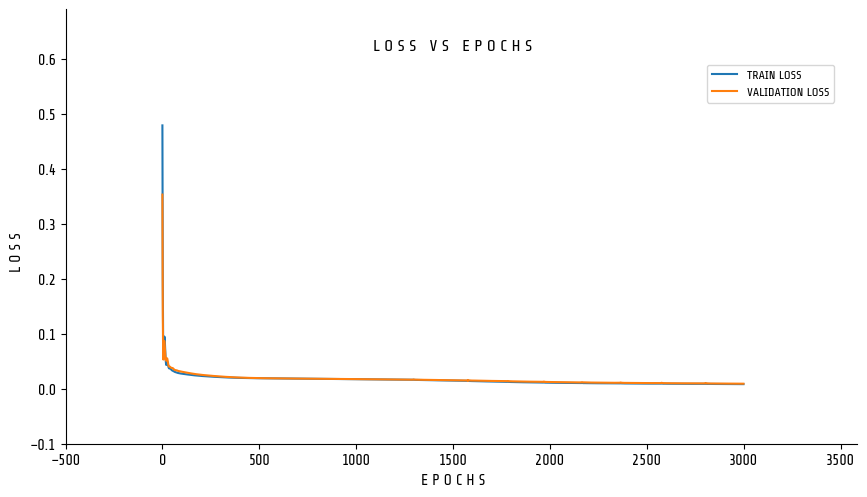

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
utils.plotting.make_fig_pretty(ax, title='Loss vs Epochs', xlabel='Epochs', ylabel='Loss',ctab=True)
plt.show()

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

Since we are training a model with MSE loss, we can also plot the predicted output against the actual output to see how well the model is performing. The predicted output should be close to the actual output, and the points should be clustered around the diagonal line. If the points are scattered far from the diagonal line, it indicates that the model is not performing well.

We can also compute the R-squared value to quantify the performance of the model. The R-squared value is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared value ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the data, and 1 indicates that the model explains all of the variance in the data.

For this step we are going to use the test set to evaluate the model. 

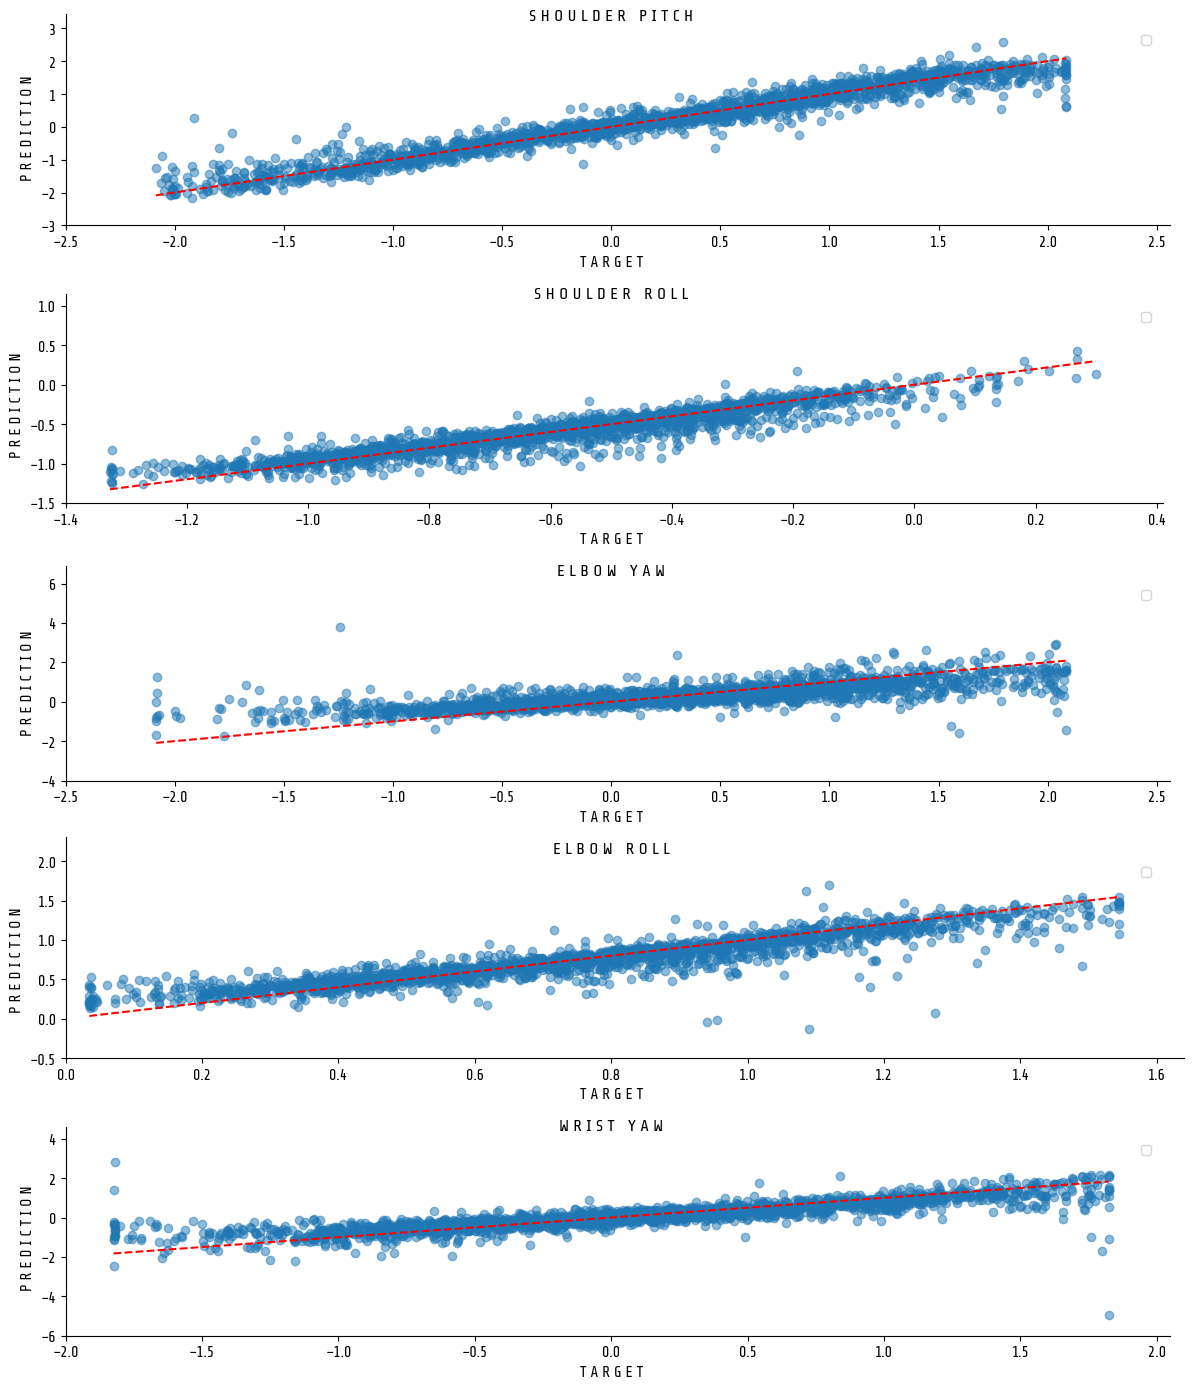

In [36]:
# Plot test vs prediction
y_test_pred = model_v1(X_test_tensor)
y_test_vals = y_test.values

# Inverse transform the predictions and targets to get the original scale
y_test_pred = y_scaler.inverse_transform(y_test_pred).detach().numpy()

joints = ['Shoulder Pitch',
          'Shoulder Roll',
          'Elbow Yaw',
          'Elbow Roll',
          'Wrist Yaw']
fig, ax = plt.subplots(figsize=(12, 14), nrows=5, ncols=1)

for ix in range(5):
    ax[ix].scatter(y_test_vals[:, ix], y_test_pred[:, ix], alpha=0.5)
    ax[ix].plot([y_test_vals[:, ix].min(), y_test_vals[:, ix].max()],
               [y_test_vals[:, ix].min(), y_test_vals[:, ix].max()], 'r--')
    ax[ix].set_xlim(y_test_vals[:, ix].min(), y_test_vals[:, ix].max())
    utils.plotting.make_fig_pretty(ax[ix], title=f'{joints[ix]}',
                         xlabel='Target', ylabel='Prediction')
plt.tight_layout()

In [38]:
def evaluate(model: torch.nn.Module,
           features: torch.Tensor,
           targets: torch.Tensor):
    
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        y_pred = model(features)
        loss = model.criterion(y_pred, targets)

    return loss.item()

loss = evaluate(model_v1, X_test_tensor, y_test_tensor)

# Create predictions to compute the R2 score
model_v1.eval()
with torch.no_grad():
    y_pred = model_v1(X_test_tensor)
    y_pred = y_scaler.inverse_transform(y_pred)

y_test_eval = y_scaler.inverse_transform(y_test_tensor)
print(f"R2 Score: {utils.ml.r2_score(y_test_eval, y_pred)}")
print(f"Test Loss: {loss:.4f}")

R2 Score: 0.8410511016845703
Test Loss: 0.0090
